In [309]:
! pip install -U langgraph --quiet
! pip install -U langchain-anthropic --quiet
! pip install -U langchain_openai --quiet
! pip install -U langchain --quiet
! pip install -U langchainhub --quiet
! pip install -U Pillow --quiet
! pip install -U python-dotenv --quiet



In [3]:
import os

from dotenv import load_dotenv
import os

# Load the .env file
load_dotenv()

# Confirm keys are set
assert os.getenv("OPENAI_API_KEY") is not None, "OPENAI_API_KEY is not set"
assert os.getenv("GMAPS_API_KEY") is not None, "GMAPS_API_KEY is not set"

In [4]:
import requests
import random
import polyline
import math
import base64
from typing import List, Tuple, Optional

class CityWalker:
    """A virtual pedestrian that can generate random walking paths in San Francisco."""
    def __init__(self):
        self.path = []
        self.current_index = 0
        self.total_distance = 0
        self.walk_complete = False

    def generate_random_path(self, max_distance: float = 5000, start_lat: Optional[float] = None, start_lng: Optional[float] = None):
        """
        Generate a random walking path in San Francisco with an approximate maximum distance.
        
        :param max_distance: Approximate maximum distance of the path in meters
        :param start_lat: Optional starting latitude
        :param start_lng: Optional starting longitude
        """
        # Approximate bounding box for San Francisco
        sf_bounds = {
            'min_lat': 37.708295, 'max_lat': 37.812496,
            'min_lng': -122.513642, 'max_lng': -122.357137
        }

        attempts = 0
        max_attempts = 20

        while attempts < max_attempts:
            if start_lat is None or start_lng is None:
                start_lat = random.uniform(sf_bounds['min_lat'], sf_bounds['max_lat'])
                start_lng = random.uniform(sf_bounds['min_lng'], sf_bounds['max_lng'])
            
            # Generate a random angle
            angle = random.uniform(0, 2 * math.pi)
            
            # Calculate end point approximately max_distance away
            delta_lat = (max_distance / 111111) * math.cos(angle)
            delta_lng = (max_distance / (111111 * math.cos(math.radians(start_lat)))) * math.sin(angle)
            
            end_lat = start_lat + delta_lat
            end_lng = start_lng + delta_lng
            
            # Ensure end point is within San Francisco bounds
            end_lat = max(min(end_lat, sf_bounds['max_lat']), sf_bounds['min_lat'])
            end_lng = max(min(end_lng, sf_bounds['max_lng']), sf_bounds['min_lng'])

            url = f"https://maps.googleapis.com/maps/api/directions/json?origin={start_lat},{start_lng}&destination={end_lat},{end_lng}&mode=walking&key={os.environ['GMAPS_API_KEY']}"
            response = requests.get(url)
            data = response.json()

            if data['status'] == 'OK':
                route = data['routes'][0]
                distance = route['legs'][0]['distance']['value']  # Distance in meters
                if distance <= max_distance * 1.4 and distance >= max_distance * 0.6:  # Allow 20% margin
                    self.path = self.decode_path(route)
                    self.total_distance = distance
                    print(f"Generated path with distance: {distance} meters")
                    print(f"Start: {start_lat}, {start_lng}")
                    print(f"End: {end_lat}, {end_lng}")
                    return
            
            attempts += 1

        print(f"Failed to generate a suitable path after {max_attempts} attempts.")

    def decode_path(self, route) -> List[Tuple[float, float]]:
        """Decode the polyline path from the route."""
        path = []
        for step in route['legs'][0]['steps']:
            points = polyline.decode(step['polyline']['points'])
            path.extend(points)
        return path

    def get_path_map_image(self, width: int = 600, height: int = 400) -> bytes:
        """
        Generate an image of the path on a map.
        
        :param width: Width of the image in pixels
        :param height: Height of the image in pixels
        :return: Image data as bytes
        """
        if not self.path:
            raise ValueError("No path has been generated yet.")

        # Encode the path for the URL
        path_encoded = polyline.encode([(lat, lng) for lat, lng in self.path])

        # Construct the URL for the static map
        url = f"https://maps.googleapis.com/maps/api/staticmap?size={width}x{height}&path=enc:{path_encoded}&key={os.environ['GMAPS_API_KEY']}"

        # Add markers for start and end points
        start_lat, start_lng = self.path[0]
        end_lat, end_lng = self.path[-1]
        url += f"&markers=color:green|label:S|{start_lat},{start_lng}"
        url += f"&markers=color:red|label:E|{end_lat},{end_lng}"

        # Add marker for current position if walk is not complete
        if not self.walk_complete:
            current_lat, current_lng = self.path[self.current_index]
            url += f"&markers=color:blue|label:C|{current_lat},{current_lng}"

        response = requests.get(url)
        if response.status_code == 200:
            return response.content
        else:
            raise Exception(f"Failed to retrieve map image: {response.status_code}")

    def get_street_view_image(self, size: str = "200x300", base64_encode: bool = True) -> bytes:
        """
        Get a Google Street View image for the current position and heading.
        
        :param size: Size of the image in pixels (width x height)
        :return: Image data as bytes
        """
        if not self.path:
            raise ValueError("No path has been generated yet.")

        current_position = self.get_current_position()
        heading = self.calculate_heading()

        url = f"https://maps.googleapis.com/maps/api/streetview?fov=100&size={size}&format=png&location={current_position[0]},{current_position[1]}&heading={heading}&pitch=0&source=outdoor&key={os.environ['GMAPS_API_KEY']}"

        response = requests.get(url)
        if response.status_code == 200:
            if not base64_encode:
                return response.content
            
            return base64.b64encode(response.content).decode()
        else:
            raise Exception(f"Failed to retrieve Street View image: {response.status_code}")

    def calculate_heading(self) -> float:
        """
        Calculate the current heading based on the current position and the next point in the path.
        
        :return: Heading in degrees (0-360)
        """
        if self.current_index >= len(self.path) - 1:
            # If we're at the end of the path, use the heading from the last two points
            if self.current_index > 0:
                start = self.path[self.current_index - 1]
                end = self.path[self.current_index]
            else:
                # If there's only one point in the path, default to North
                return 0
        else:
            start = self.path[self.current_index]
            end = self.path[self.current_index + 1]

        delta_lng = end[1] - start[1]
        delta_lat = end[0] - start[0]
        heading = math.atan2(delta_lng, delta_lat) * 180 / math.pi
        return (heading + 360) % 360

    def walk(self, distance: float = 50) -> Tuple[float, float]:
        """
        Advance the virtual pedestrian along the path.
        
        :param distance: Distance to walk in meters
        :return: New position (latitude, longitude)
        """
        if self.walk_complete:
            print("Walk is already complete.")
            return self.path[-1]

        remaining_distance = distance
        while remaining_distance > 0 and self.current_index < len(self.path) - 1:
            start = self.path[self.current_index]
            end = self.path[self.current_index + 1]
            segment_distance = self.haversine_distance(start[0], start[1], end[0], end[1])

            if segment_distance <= remaining_distance:
                self.current_index += 1
                remaining_distance -= segment_distance
            else:
                fraction = remaining_distance / segment_distance
                lat = start[0] + fraction * (end[0] - start[0])
                lng = start[1] + fraction * (end[1] - start[1])
                self.path[self.current_index] = (lat, lng)
                remaining_distance = 0

        if self.current_index == len(self.path) - 1:
            self.walk_complete = True
            print("Reached the end of the path. Walk complete.")

        return self.path[self.current_index]
    
    def summary(self) -> str:
        """Get a summary of the walk."""
        if not self.path:
            return "No path has been generated yet."

        current_position = self.get_current_position()
        progress = self.get_progress()
        summary = f"Progress: {progress:.1f}% | "
        summary += f"Walk complete: {self.walk_complete}"
        return summary

    @staticmethod
    def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
        R = 6371000  # Earth's radius in meters
        phi1 = math.radians(lat1)
        phi2 = math.radians(lat2)
        delta_phi = math.radians(lat2 - lat1)
        delta_lambda = math.radians(lon2 - lon1)

        a = (math.sin(delta_phi / 2) * math.sin(delta_phi / 2) +
             math.cos(phi1) * math.cos(phi2) *
             math.sin(delta_lambda / 2) * math.sin(delta_lambda / 2))
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

        return R * c

    def get_current_position(self) -> Tuple[float, float]:
        """Get the current position of the virtual pedestrian."""
        return self.path[self.current_index]

    def get_progress(self) -> float:
        """Get the progress of the walk as a percentage."""
        if not self.path:
            return 0
        current_distance = sum(self.haversine_distance(self.path[i][0], self.path[i][1], 
                                                       self.path[i+1][0], self.path[i+1][1])
                               for i in range(self.current_index))
        return (current_distance / self.total_distance) * 100

In [8]:
from langchain.prompts.chat import ChatPromptTemplate
from langchain.prompts.chat import SystemMessagePromptTemplate
from langchain.prompts.chat import MessagesPlaceholder
from langchain.prompts.chat import HumanMessagePromptTemplate
from langchain.prompts import PromptTemplate
from langchain_core.prompts.image import ImagePromptTemplate
from langchain_openai import ChatOpenAI

ACTION_PROMPT = """Imagine you are a psychogeographer taking a dérive through a city.
Imagine your city as a living, breathing entity with hidden stories etched into every street corner, alleyway, and building facade. 
Your mission is to write an narratives and experience your urban environment in entirely new ways.

Now you will walk through the city and write a story about your experience. 
In each iteration, you will receive an Observation that includes a photo of the city and your progress so far.
Carefully analyze the photo then choose one of the following actions:

1. Continue on your walk.
2. Decide to take a detour as the experience of the cityscape has inspired you to explore a new area.
3. End your walk and reflect on your experience as your have arrived at your destination.

Correspondingly, Action should STRICTLY follow the format:

- CONTINUE
- DETOUR [north, south, east or west]
- END [short thoughts on your experience]

Key Guidelines You MUST follow:

* Action guidelines *
1. Execute only one action per iteration.
2. Do not take too many detours. Your goal is to eventually go where you intended.
3. Avoid ending your walk too soon. You should have a substantial experience before ending.

Your reply should strictly follow the format:
Thought: {{Your brief but elegant thoughts in 1-2 sentences on the photo as a psychogeographer}}
Action: {{One Action format you choose}}
Then the User will provide:
Observation: {{Your progress so far on the walk}}
"""

prompt = ChatPromptTemplate(
  messages=[
    SystemMessagePromptTemplate(
      prompt=[
        PromptTemplate.from_template(ACTION_PROMPT),
      ],
    ),
    MessagesPlaceholder(
      optional=True,
      variable_name="scratchpad",
    ),
    HumanMessagePromptTemplate(
      prompt=[
        ImagePromptTemplate(
          template={"url":"data:image/png;base64,{img}"},
          input_variables=[
            "img",
          ],
        ),
        PromptTemplate.from_template("{progress}"),
      ],
    ),
  ],
  input_variables=[
    "img",
    "progress",
  ],
  partial_variables={"scratchpad":[]},
)

llm = ChatOpenAI(model="gpt-4o", streaming=True)
generate = prompt | llm

In [221]:
from langchain_core.messages import HumanMessage

essay = ""
for chunk in generate.stream({"img": base64_img, "progress": "You are 0% done with your walk."}):
    print(chunk.content, end="")
    essay += chunk.content

Thought: The juxtaposition of modern apartment buildings and older, graffiti-adorned structures creates a visual dialogue between the past and present, hinting at the layered history of this urban space.

Action: CONTINUE

In [10]:
from typing import List, Optional, TypedDict

from langchain_core.messages import BaseMessage, SystemMessage

class Prediction(TypedDict):
    action: str
    thought: str
    args: Optional[List[str]]


class AgentState(TypedDict):
    walker: CityWalker
    img: [str]  # b64 encoded photos of the walk
    thoughts: [str] # thoughts during the walk
    progress: str # Progress so far
    prediction: Prediction  # The Agent's output
    # A system message (or messages) containing the intermediate steps
    scratchpad: List[BaseMessage]


In [11]:
def walk(state: AgentState):
    walker = state["walker"]
    walker.walk()
    return walker.summary()

def detour(state: AgentState):
    raise NotImplemented


import re

def update_scratchpad(state: AgentState):
    """After a tool is invoked, we want to update
    the scratchpad and new surroundings so the agent is aware of its previous steps"""
    old = state.get("scratchpad")
    if old:
        txt = old[0].content
        last_line = txt.rsplit("\n", 1)[-1]
        step = int(re.match(r"\d+", last_line).group()) + 1
    else:
        txt = "Previous action observations:\n"
        step = 1
    txt += f"\n{step}. {state['progress']}"
    # update images
    imgs = state.get("img")
    new_image = state.get("walker").get_street_view_image()
    imgs.append(new_image)
    # update thoughts
    thoughts = state.get("thoughts")
    new_thought = state["prediction"]["thought"]
    thoughts.append(new_thought)
    return {**state, "scratchpad": [SystemMessage(content=txt)], "img": imgs, "thoughts": thoughts}

def parse(text: str) -> dict:
    action_prefix = "Action: "
    thought_prefix = "Thought:"
    if not text.strip().split("\n")[-1].startswith(action_prefix):
        return {"action": "retry", "args": f"Could not parse LLM action Output: {text}"}
    action_block = text.strip().split("\n")[-1]

    if not text.strip().split("\n")[0].startswith(thought_prefix):
        return {"action": "retry", "args": f"Could not parse LLM thought Output: {text}"}
    thought_block = text.strip().split("\n")[0]
    thought_str = thought_block[len(thought_prefix) :]

    action_str = action_block[len(action_prefix) :]
    split_output = action_str.split(" ", 1)
    if len(split_output) == 1:
        action, action_input = split_output[0], None
    else:
        action, action_input = split_output
    action = action.strip()
    if action_input is not None:
        action_input = [
            inp.strip().strip("[]") for inp in action_input.strip().split(";")
        ]
    return {"action": action, "thought": thought_str, "args": action_input}

from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

agent = RunnablePassthrough.assign(
    prediction=prompt | llm | StrOutputParser() | parse
)

In [12]:
from langchain_core.runnables import RunnableLambda
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, StateGraph

graph_builder = StateGraph(AgentState)

graph_builder.add_node("agent", agent)
graph_builder.set_entry_point("agent")

graph_builder.add_node("update_scratchpad", update_scratchpad)
graph_builder.add_edge("update_scratchpad", "agent")

tools = {
    "CONTINUE": walk,
    "DETOUR": detour,
}

for node_name, tool in tools.items():
    graph_builder.add_node(
        node_name,
        # The lambda ensures the function's string output is mapped to the "observation"
        # key in the AgentState
        RunnableLambda(tool) | (lambda p: {"progress": p}),
    )
    # Always return to the agent (by means of the update-scratchpad node)
    graph_builder.add_edge(node_name, "update_scratchpad")


def select_tool(state: AgentState):
    # Any time the agent completes, this function
    # is called to route the output to a tool or
    # to the end user.
    action = state["prediction"]["action"]

    if action == "END":
        return END
    if action == "retry":
        return "agent"
    return action


graph_builder.add_conditional_edges("agent", select_tool)

checkpointer = MemorySaver()

graph = graph_builder.compile(checkpointer=checkpointer)

Generated path with distance: 401 meters
Start: 37.742648851306406, -122.4113517300027
End: 37.74342228488297, -122.40808041160784


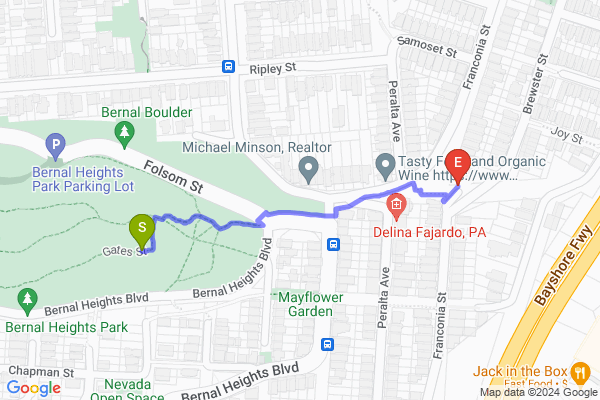

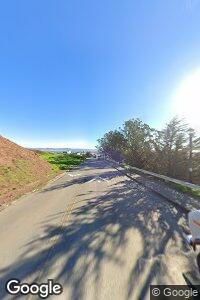

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAx


In [15]:
from IPython.display import display, Image

# generate a new walk
walker = CityWalker()
walker.generate_random_path(max_distance=300)
display(Image(walker.get_path_map_image()))
display(Image(walker.get_street_view_image(base64_encode=False)))
print(walker.get_street_view_image()[0:100])

Action: CONTINUE

Progress: Progress: 0.0% | Walk complete: False

Scratchpad: []



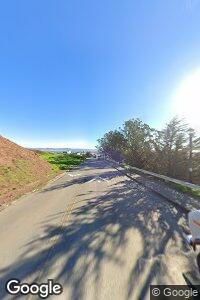

Action: retry

Progress: Progress: 12.5% | Walk complete: False

Scratchpad: [SystemMessage(content='Previous action observations:\n\n1. Progress: 12.5% | Walk complete: False')]



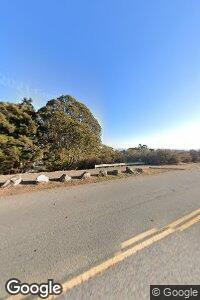

Action: CONTINUE

Progress: Progress: 12.5% | Walk complete: False

Scratchpad: [SystemMessage(content='Previous action observations:\n\n1. Progress: 12.5% | Walk complete: False')]



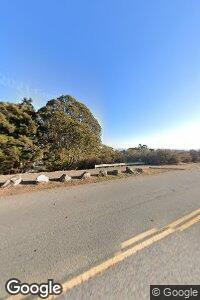

GraphRecursionError: Recursion limit of 5 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [17]:
steps = []

start_input = {
        "walker": walker,
        "img": [walker.get_street_view_image()],
        "thoughts": [],
        "progress": walker.summary(), 
        "scratchpad": []
    }

def summarize_progress(chunk: dict):
    if "agent" not in chunk:
        return

    pred = chunk["agent"].get("prediction") or {}
    progress = chunk["agent"].get("progress") or {}
    action = pred.get("action")
    sp = chunk["agent"].get("scratchpad")
    
    action_input = pred.get("args")
    print(f"Action: {action}\n")
    print(f"Progress: {progress}\n")
    print(f"Scratchpad: {sp}\n")
    base64_img = chunk["agent"]["img"][-1]
    display(Image(base64.b64decode(base64_img)))

for chunk in graph.stream(
    start_input,
    config={"configurable": {"thread_id": "42"}, "recursion_limit": 5 }):
    summarize_progress(chunk)


Action: CONTINUE

Progress: Progress: 0.0% | Walk complete: False

Scratchpad: []



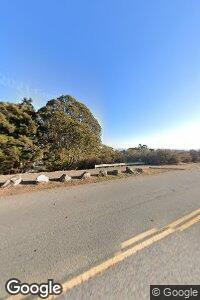

Action: CONTINUE

Progress: Progress: 24.9% | Walk complete: False

Scratchpad: [SystemMessage(content='Previous action observations:\n\n1. Progress: 24.9% | Walk complete: False')]



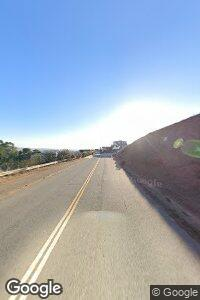

Action: CONTINUE

Progress: Progress: 37.4% | Walk complete: False

Scratchpad: [SystemMessage(content='Previous action observations:\n\n1. Progress: 24.9% | Walk complete: False\n2. Progress: 37.4% | Walk complete: False')]



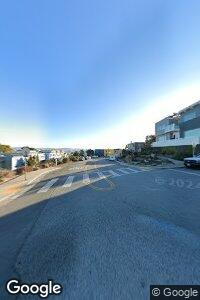

Action: CONTINUE

Progress: Progress: 49.9% | Walk complete: False

Scratchpad: [SystemMessage(content='Previous action observations:\n\n1. Progress: 24.9% | Walk complete: False\n2. Progress: 37.4% | Walk complete: False\n3. Progress: 49.9% | Walk complete: False')]



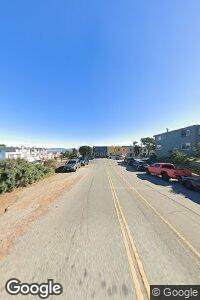

Action: CONTINUE

Progress: Progress: 62.3% | Walk complete: False

Scratchpad: [SystemMessage(content='Previous action observations:\n\n1. Progress: 24.9% | Walk complete: False\n2. Progress: 37.4% | Walk complete: False\n3. Progress: 49.9% | Walk complete: False\n4. Progress: 62.3% | Walk complete: False')]



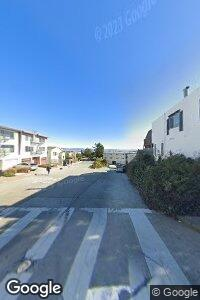

GraphRecursionError: Recursion limit of 15 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.

In [18]:
for chunk in graph.stream(
    start_input, 
    config={"configurable": {"thread_id": "42"}, "recursion_limit": 15 }):
    summarize_progress(chunk)